## Import Libaries

In [1]:
# Standard libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()   
import configparser
import os
from pathlib import Path
import argparse
import logging
import datetime
import inspect
from sklearn.utils import resample
import re
from datetime import datetime
from datetime import timedelta
import plotly.express as px
import plotly.graph_objs as go
import math

# skLearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Sktime
from sktime.classification.kernel_based import RocketClassifier
from sktime.datatypes import check_raise
from sktime.datatypes import mtype
from sktime.datatypes import check_is_mtype
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.series.summarize import SummaryTransformer
from sktime.datatypes import convert_to
from sktime.datatypes import convert
from sktime.transformations.panel.rocket import MiniRocketMultivariate

# Additional
import matplotlib.dates as mdates
import joblib
import time # to claculate the runtime of models
from pathlib import Path 
import pymannkendall as mk # Kendall tau trend package

# Internal Packages
from analyse_df import analyse_df
from rename_columns import rename_columns
import plot_settings

# SHAP Explanation
import shap

# Vizualization with streamlit
import inspect
import textwrap
import streamlit as st

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Get the current directory
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')

## Import data

In [3]:
# Import SHAP values df
# Construct the absolute path to the data file
file_name = 'df_shap_values_elba_rocket.csv'
data_file_path = os.path.join(data_path, file_name)

df_shap_values = pd.read_csv(data_file_path, index_col=0)

In [4]:
# Import X_test_elba_rocket
# Construct the absolute path to the data file
file_name = 'df_test_elba_rocket.csv'
data_file_path = os.path.join(data_path, file_name)

df_test = pd.read_csv(data_file_path, index_col=0)

In [7]:
selected_interval = 724

In [8]:
list_sensornodes = ['8','9','10','11','12','13','14','15','16']

In [14]:
# Define data for Sensor measurements plot
data_temp_shap_values = df_shap_values.copy()
data_temp_shap_values = data_temp_shap_values.loc[data_temp_shap_values.index == selected_interval]

# Set the index to 'Timepoints' for better visualization
data_temp_shap_values.set_index('timepoints', inplace=True)

# Get a list of unique sensors
sensors = list_sensornodes

In [21]:
# print(data_temp_shap_values[['CO_Room_10', 'CO_Room_11', 'CO_Room_12', 'CO_Room_13', 'CO_Room_14','CO_Room_15', 'CO_Room_16','CO_Room_8', 'CO_Room_9', 'CO_Room_Trend_10']].to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & CO_Room_10 & CO_Room_11 & CO_Room_12 & CO_Room_13 & CO_Room_14 & CO_Room_15 & CO_Room_16 & CO_Room_8 & CO_Room_9 & CO_Room_Trend_10 \\
timepoints &  &  &  &  &  &  &  &  &  &  \\
\midrule
0 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.027120 & 0.000000 \\
10 & 0.000000 & 0.000000 & 0.000000 & -0.007992 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.017156 \\
20 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & -0.024213 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
30 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.001103 \\
40 & 0.000000 & 0.000000 & 0.000000 & -0.016194 & 0.012849 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & -0.028147 \\
50 & 0.000000 & 0.000000 & 0.000000 & 0.007230 & 0.009781 & 0.000000 & 0.004774 & 0.008969 & 0.000000 & 0.000000 \\
60 & -0.003496 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & -0.000641 &

In [39]:
# Initialize lists to store the data
timepoints = []
sensor_ids = []
measurements = []
shap_values = []

# Iterate over the columns and create lists for each attribute
for col in data_temp_shap_values.columns:
    if col != 'timepoints':
        sensor_id = col.split('_')[-1]  # Extract the Sensor_ID
        measurement = col.rsplit('_', 1)[0]  # Extract all strings before the last "_"
        timepoints.extend(data_temp_shap_values.index)
        sensor_ids.extend([sensor_id] * len(data_temp_shap_values))
        measurements.extend([measurement] * len(data_temp_shap_values))
        shap_values.extend(data_temp_shap_values[col].tolist())

# Create the transformed DataFrame
transformed_df = pd.DataFrame({
    'timepoints': timepoints,
    'Sensor_ID': sensor_ids,
    'measurement': measurements,
    'shap_value': shap_values
})


In [48]:
# Pivot the DataFrame to calculate the mean of 'shap_value' for each 'measurement' and 'timepoints'
grouped_df = transformed_df.pivot_table(index=['measurement', 'timepoints'], values='shap_value', aggfunc='mean').reset_index()

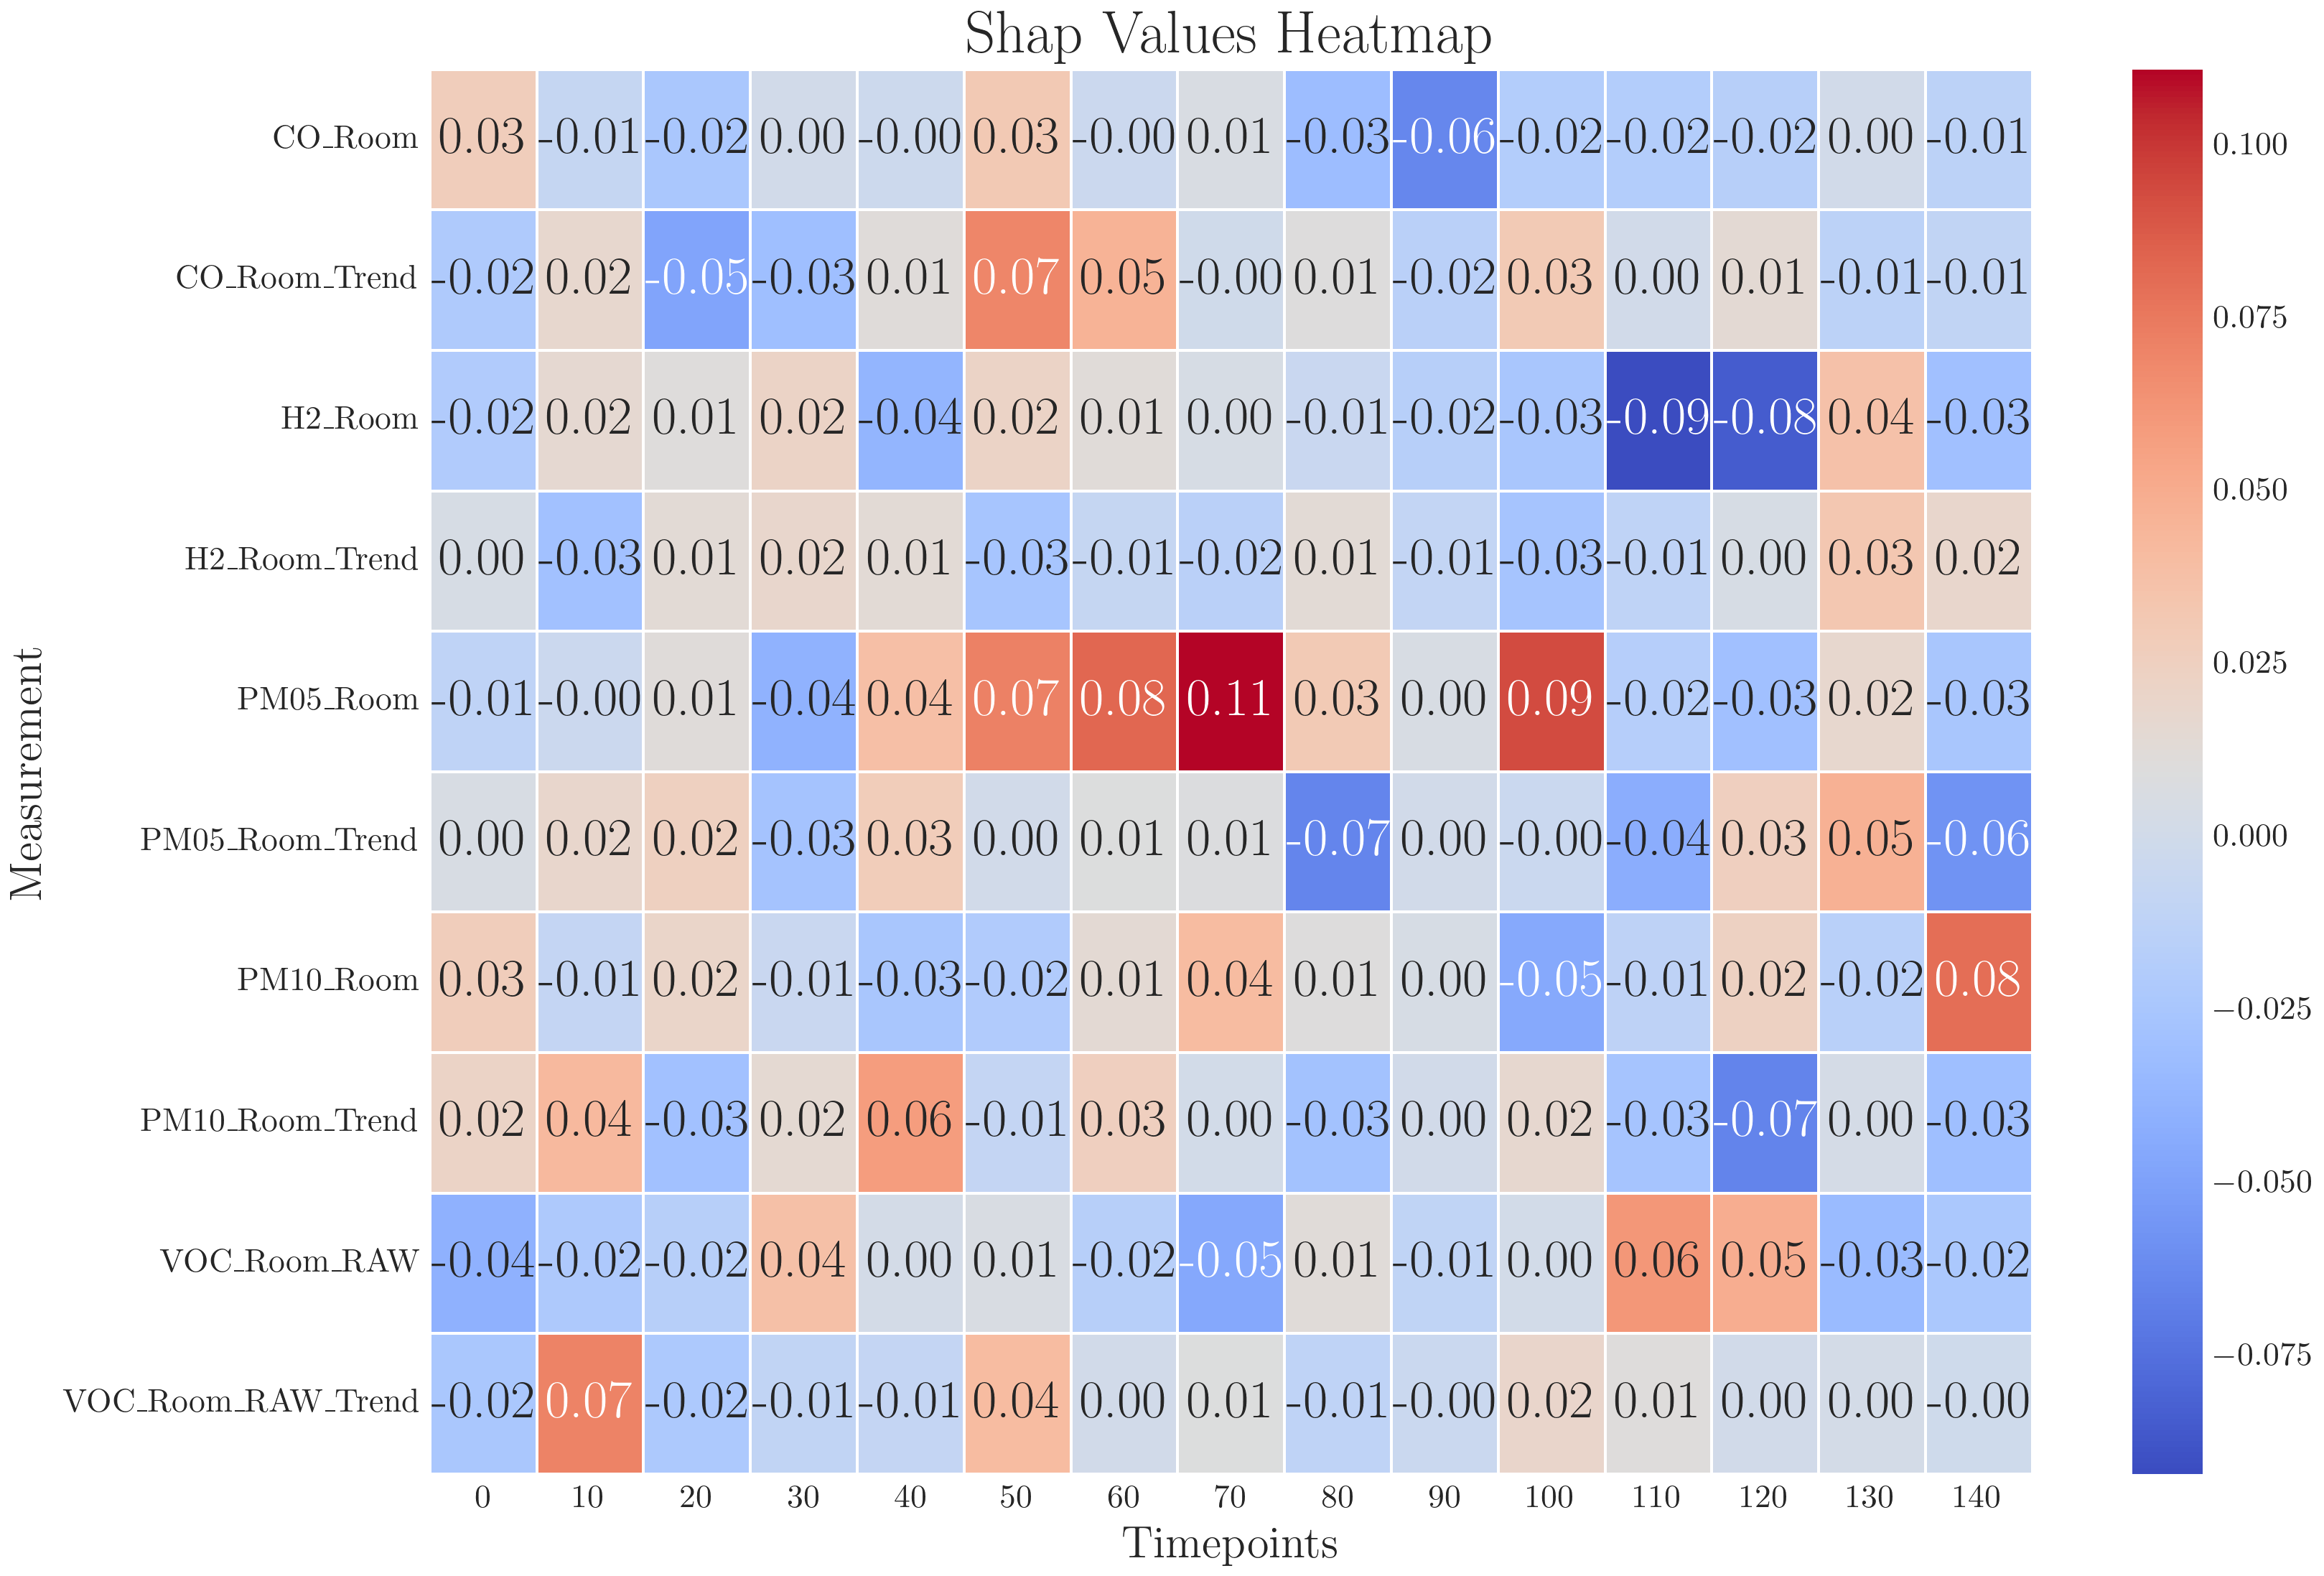

In [50]:
# Pivot the DataFrame for heatmap plotting
heatmap_data = grouped_df.pivot(index='measurement', columns='timepoints', values='shap_value')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Shap Values Heatmap')
plt.xlabel('Timepoints')
plt.ylabel('Measurement')
plt.show()